# Synthetic dataset generator

In [8]:
import pandas as pd
import numpy as np

def generate_synthetic_biomarker_data(n_samples=1000, seed=42):
    np.random.seed(seed)

    # Demographics
    age = np.random.randint(30, 80, n_samples)
    sex = np.random.choice(['male', 'female'], size=n_samples)
    smoker = np.random.choice(['yes', 'no'], size=n_samples, p=[0.3, 0.7])

    # Vitals
    sbp = np.random.normal(135, 15, n_samples).clip(90, 200)
    dbp = np.random.normal(85, 10, n_samples).clip(60, 120)

    # Lipids
    total_chol = np.random.normal(5.5, 1.2, n_samples).clip(3.0, 9.0)  # mmol/L
    hdl = np.random.normal(1.3, 0.3, n_samples).clip(0.5, 2.5)
    ldl = total_chol - hdl - np.random.normal(0.5, 0.3, n_samples)  # estimate
    triglycerides = np.random.normal(1.5, 0.8, n_samples).clip(0.4, 5.0)

    # Glycemic
    fasting_glucose = np.random.normal(5.6, 1.2, n_samples).clip(3.5, 12)

    # Renal
    creatinine = np.random.normal(1.0, 0.3, n_samples).clip(0.5, 2.0)

    # Body metrics
    bmi = np.random.normal(27, 5, n_samples).clip(18, 45)
    waist = np.random.normal(90, 15, n_samples).clip(60, 130)

    # Outcome (simulate higher risk with age, sbp, smoker)
    risk = (age > 60).astype(int) + (sbp > 140).astype(int) + (smoker == 'yes').astype(int)
    cvd_outcome = (risk >= 2).astype(int)

    df = pd.DataFrame({
        'age': age,
        'sex': sex,
        'sbp': sbp,
        'dbp': dbp,
        'total_cholesterol': total_chol,
        'hdl': hdl,
        'ldl': ldl,
        'triglycerides': triglycerides,
        'fasting_glucose': fasting_glucose,
        'creatinine': creatinine,
        'bmi': bmi,
        'waist_circumference': waist,
        'smoker': smoker,
        'cvd_outcome': cvd_outcome
    })

    return df

# Generate and save
synthetic_df = generate_synthetic_biomarker_data()
synthetic_df.to_csv("synthetic_biomarkers.csv", index=False)
print(" Synthetic dataset created with shape:", synthetic_df.shape)


 Synthetic dataset created with shape: (1000, 14)


Data preprocessing

In [9]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load dataset (replace with actual path)
data = pd.read_csv("/content/synthetic_biomarkers.csv")

# # Define biomarker and risk-related columns
# biomarker_features = [
#     'age', 'sex', 'sbp', 'dbp', 'total_cholesterol', 'hdl', 'ldl',
#     'triglycerides', 'fasting_glucose', 'creatinine', 'bmi',
#     'waist_circumference', 'smoker'
# ]

# Basic preprocessing
def preprocess_biomarker_data(df):
    df = df.copy()

    # Derived Features
    df['tc_hdl_ratio'] = df['total_cholesterol'] / (df['hdl'] + 1e-5)

    # eGFR approximation using MDRD formula (for adults)
    df['egfr'] = 175 * (df['creatinine'] ** -1.154) * (df['age'] ** -0.203)
    df.loc[df['sex'] == 'female', 'egfr'] *= 0.742  # Female correction

    # Convert categorical columns
    df['sex'] = df['sex'].map({'male': 1, 'female': 0})
    df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

    # Handle missing values and scale
    imputer = SimpleImputer(strategy='constant')
    scaler = StandardScaler()

    biomarker_data = [
        'age', 'sex', 'sbp', 'dbp', 'total_cholesterol', 'hdl', 'ldl', 'triglycerides',
        'fasting_glucose', 'creatinine', 'bmi', 'waist_circumference', 'smoker',
        'tc_hdl_ratio', 'egfr'
    ]

    X = df[biomarker_data]

    imputed = imputer.fit_transform(X)
    scaled = scaler.fit_transform(imputed)

    # Save preprocessed data to CSV
    preprocessed_df = pd.DataFrame(scaled, columns=biomarker_data)
    preprocessed_df['cvd_outcome'] = df['cvd_outcome'].values  # append label
    preprocessed_df.to_csv("preprocessed_biomarkers.csv", index=False)

    return scaled, imputer, scaler

# Preprocess
X_processed, imputer_obj, scaler_obj = preprocess_biomarker_data(data)

print(f"Preprocessed biomarker data shape: {X_processed.shape}")


Preprocessed biomarker data shape: (1000, 15)


In [10]:
X_processed

array([[ 0.91843349,  0.9492843 ,  0.76077999, ...,  1.51668389,
         0.18702611, -0.3382    ],
       [ 0.22106562,  0.9492843 ,  0.58238987, ..., -0.65933317,
        -0.73133826, -0.52878608],
       [-0.75524941,  0.9492843 , -0.52163707, ...,  1.51668389,
         1.2953893 , -0.21348475],
       ...,
       [ 1.33685421, -1.05342519, -0.23297708, ..., -0.65933317,
         0.78188682, -0.65344654],
       [-1.38288049, -1.05342519, -1.81260399, ..., -0.65933317,
         1.331804  , -0.71099507],
       [ 0.77895992,  0.9492843 ,  0.60232785, ..., -0.65933317,
         0.49054208,  0.51505794]])

Test preprocessing

In [11]:
data = pd.read_csv("preprocessed_biomarkers.csv")
X_processed, imputer_obj, scaler_obj = preprocess_biomarker_data(data)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


Biomarker Feature Checklist

In [12]:
expected_columns = [
    'age', 'sex', 'sbp', 'dbp', 'total_cholesterol', 'hdl', 'ldl',
    'triglycerides', 'fasting_glucose', 'creatinine', 'bmi',
    'waist_circumference', 'smoker'
]

data = pd.read_csv("preprocessed_biomarkers.csv")
actual_columns = data.columns.tolist()

# Check missing columns
missing = [col for col in expected_columns if col not in actual_columns]
extra = [col for col in actual_columns if col not in expected_columns]

print("Expected Columns Found:", [col for col in expected_columns if col in actual_columns])
if missing:
    print("⚠️ Missing Columns:", missing)
if extra:
    print("Extra Columns (not used in preprocessing):", extra)


Expected Columns Found: ['age', 'sex', 'sbp', 'dbp', 'total_cholesterol', 'hdl', 'ldl', 'triglycerides', 'fasting_glucose', 'creatinine', 'bmi', 'waist_circumference', 'smoker']
Extra Columns (not used in preprocessing): ['tc_hdl_ratio', 'egfr', 'cvd_outcome']


Visualization of preprocessed data

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


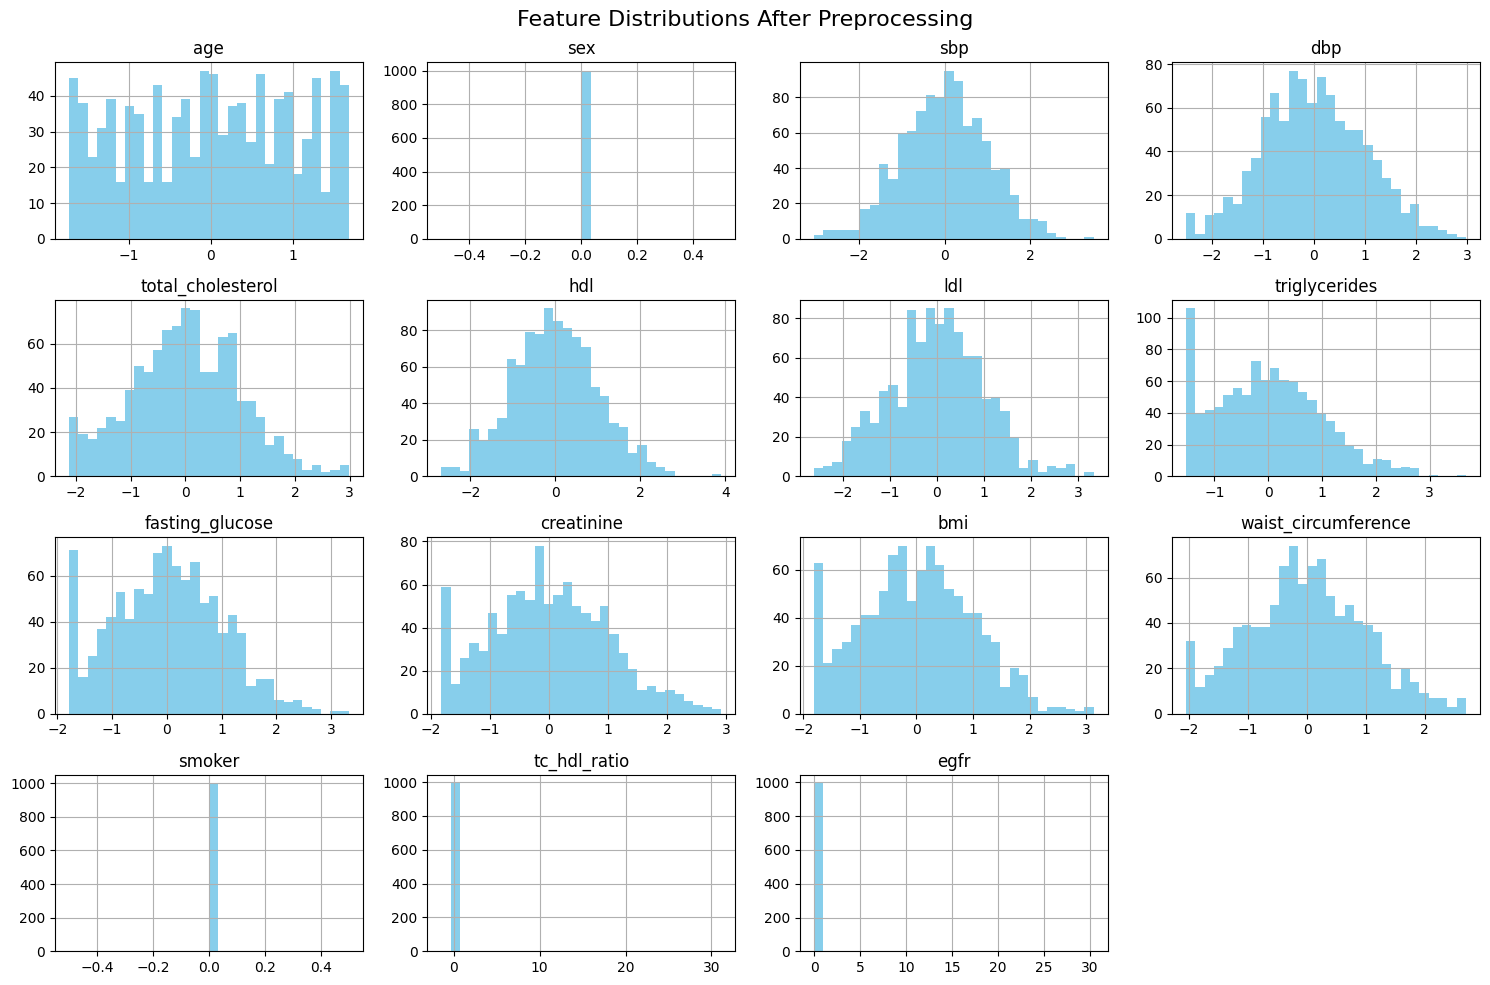

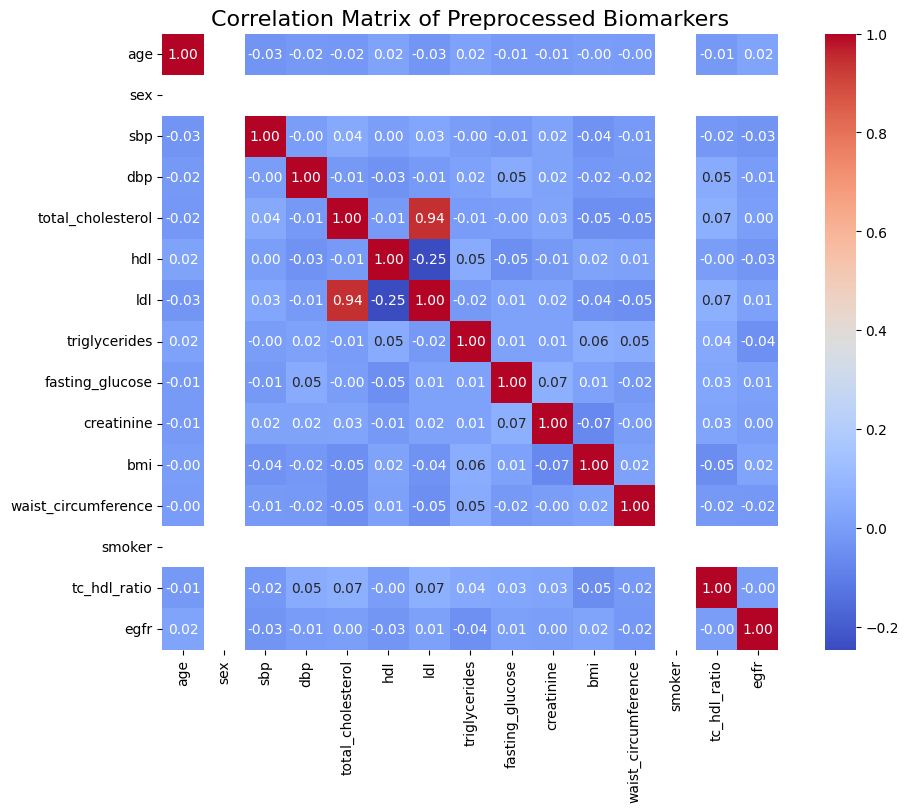

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Run preprocessing
X_processed, _, _ = preprocess_biomarker_data(data)

# Convert scaled array back to DataFrame for inspection
processed_df = pd.DataFrame(X_processed, columns=[
    'age', 'sex', 'sbp', 'dbp', 'total_cholesterol', 'hdl', 'ldl',
    'triglycerides', 'fasting_glucose', 'creatinine', 'bmi',
    'waist_circumference', 'smoker', 'tc_hdl_ratio', 'egfr'
])

# Histograms
processed_df.hist(bins=30, figsize=(15, 10), color='skyblue')
plt.suptitle("Feature Distributions After Preprocessing", fontsize=16)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(processed_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Preprocessed Biomarkers", fontsize=16)
plt.show()


# Modules for baseline based on research papers
Cardiovascular Risk Prediction Modules for African Cohorts

Each module is derived from a peer-reviewed study

In [14]:
# ---------------- MODULE 1 ----------------
# Based on: Assessment of cardiovascular risk in a slum population in Kenya using WHO/ISH charts

def who_ish_nonlab_kenya_risk(age, sex, sbp, smoking, diabetes):
    """
    Predicts CVD risk using WHO/ISH non-lab chart approach (East Africa region)
    Inputs: age (years), sex ('M'/'F'), sbp (mmHg), smoking (bool), diabetes (bool)
    Output: Risk category as string
    """
    risk_score = 0
    if age >= 60: risk_score += 2
    elif age >= 50: risk_score += 1
    if sbp >= 160: risk_score += 2
    elif sbp >= 140: risk_score += 1
    if smoking: risk_score += 2
    if diabetes: risk_score += 2

    if risk_score >= 6:
        return ">30% risk"
    elif risk_score >= 4:
        return "10–30% risk"
    else:
        return "<10% risk"

# Title: Assessment of cardiovascular risk in a slum population in Kenya using WHO/ISH charts
# Link: https://ht.amegroups.org/article/view/7398/html

In [15]:
# ---------------- MODULE 2 ----------------
# Based on: QRISK performance in sub-Saharan settings

def qrisk_africa(age, sex, sbp, cholesterol_ratio, smoker, diabetic, bmi):
    """
    Simplified version of QRISK adapted to African context (placeholder coefficients)
    """
    coef = {
        'age': 0.05,
        'sex': -0.3 if sex == 'F' else 0,
        'sbp': 0.02,
        'cholesterol_ratio': 0.1,
        'smoker': 0.6,
        'diabetic': 0.7,
        'bmi': 0.03
    }
    risk_score = (coef['age'] * age + coef['sbp'] * sbp + coef['cholesterol_ratio'] * cholesterol_ratio +
                  coef['smoker'] * int(smoker) + coef['diabetic'] * int(diabetic) + coef['bmi'] * bmi + coef['sex'])
    return round(min(max(risk_score * 2.5, 0), 100), 2)  # bounded percentage

# Title: Cardiovascular disease risk prediction using QRISK scores in low-income settings
# Link: https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-018-6052-y

In [16]:
# ---------------- MODULE 3 ----------------
# Based on: WHO/ISH risk prediction charts without cholesterol

def who_ish_nochol_generic(age, sbp, diabetes, smoker):
    """
    WHO/ISH non-lab adapted scoring method
    """
    score = 0
    score += (age // 10) * 1
    score += (sbp - 120) // 10 * 1
    if diabetes: score += 2
    if smoker: score += 2
    if score > 9:
        return ">30%"
    elif score > 5:
        return "10–30%"
    else:
        return "<10%"

# Title: Application of WHO/ISH risk charts without cholesterol in African settings
# Link: http://dx.doi.org/10.1136/bmjopen-2019-029304

In [17]:
# ---------------- MODULE 4 ----------------
# Based on: CVD Risk Tools vs Actual Mortality in African Slums

def adjust_risk_with_context(base_risk, poverty_score, health_access_score):
    """
    Adjust risk prediction based on contextual modifiers
    """
    adjusted = base_risk + (1 - health_access_score) * 10 + poverty_score * 5
    return min(round(adjusted, 2), 100)

# Title: Mortality from cardiovascular diseases in Nairobi slums
# Link: https://globalheartjournal.com/articles/10.5334/gh.787

In [18]:

# ---------------- MODULE 5 ----------------
# Based on: Calibration of FRS and PCE in Nairobi population

def recalibrated_frs(age, sex, sbp, smoker, diabetic, cholesterol, hdl):
    """
    FRS recalibrated with coefficients from Nairobi cohort study
    """
    base_score = 0.02 * age + 0.04 * sbp + 0.5 * int(smoker) + 0.6 * int(diabetic)
    if cholesterol and hdl:
        base_score += 0.03 * (cholesterol / hdl)
    return round(min(base_score * 10, 100), 2)

# Title: Comparison of Framingham and Pooled Cohort Equations in a slum population in Nairobi
# Link: https://www.sciencedirect.com/science/article/pii/S2352906719302210?via%3Dihub


In [19]:
# ---------------- MODULE 6 ----------------
# Based on: BMJ Open – WHO/ISH chart application validation

def who_ish_validation_logic(age, sbp, smoker, diabetes):
    """
    Simplified logic extracted from BMJ Open paper
    """
    risk_factor = age * 0.1 + sbp * 0.05
    if smoker:
        risk_factor += 10
    if diabetes:
        risk_factor += 15
    if risk_factor > 40:
        return "High Risk"
    elif risk_factor > 20:
        return "Moderate Risk"
    else:
        return "Low Risk"

# Title: WHO/ISH non-lab chart validation in African populations
# Link: https://bmjopen.bmj.com/content/9/6/e026852


#Globorisk Statistical Model
### a. Model Type
Cox proportional hazards model: A regression model commonly used for survival analysis. It estimates the hazard (or risk) of an event occurring as a function of time and covariates (risk factors).

### b. Data Sources
Derived from Emerging Risk Factors Collaboration (ERFC) and Global Burden of Disease (GBD) data.

Initially based on cohorts from high-income countries, then recalibrated to local data for individual countries.

### c. Predictors (Covariates)
* Age (continuous)

* Sex (binary)

* Smoking status (binary)

* Diabetes status (binary)

* Systolic blood pressure (continuous)

* Total cholesterol (continuous)

***In "office-based" models, BMI replaces cholesterol and diabetes***

### d. Modeling Steps
Cox regression is used to estimate the baseline hazard and coefficients for each predictor using global cohort data.

Country-specific recalibration:

* Uses national-level data on CVD incidence/mortality, risk factor prevalence, and demographics to adjust the baseline hazard function.

* Enables application in countries with limited cohort data.

* Produces both laboratory-based and non-laboratory-based risk equations.

### e. Output
10-year risk of CVD (fatal or non-fatal).

Expressed as a probability (e.g., 10% risk).

---

# General Formula (Cox model):
The 10-year CVD risk is estimated as:

`  Risk(t)=1−exp(-H0
​
 (t)⋅exp(β
1
​
 X
1
​
 +β
2
​
 X
2
​
 +⋯+β
n
​
 X
n
​
 )) `

Where:
* H
0
​
 (t) = Baseline cumulative hazard at 10 years (country-specific)
* β
i
​
  = Regression coefficient for risk factor
𝑋
𝑖
X
i
​

* 𝑋
𝑖
X
i
​
  = Patient’s risk factor value (e.g., age, cholesterol, etc.)

In [20]:
import math

def globorisk_10yr_risk(age, sex, smoking, diabetes, sbp, cholesterol):
    """
    Estimate 10-year CVD risk using a simplified Globorisk-like model.

    Parameters:
    - age: int (years)
    - sex: 1 for male, 0 for female
    - smoking: 1 if smoker, 0 otherwise
    - diabetes: 1 if diabetic, 0 otherwise
    - sbp: systolic blood pressure in mmHg
    - cholesterol: total cholesterol in mmol/L

    Returns:
    - risk: float (probability between 0 and 1)
    """

    # Example coefficients for illustrative purposes
    betas = {
        'age': 0.06,
        'sex': 0.50,
        'smoking': 0.65,
        'diabetes': 0.55,
        'sbp': 0.02,
        'cholesterol': 0.25
    }

    # Country-specific baseline hazard at 10 years (example: Kenya)
    baseline_hazard = 0.015  # Adjust based on country-specific calibration

    # Linear predictor
    lp = (
        betas['age'] * age +
        betas['sex'] * sex +
        betas['smoking'] * smoking +
        betas['diabetes'] * diabetes +
        betas['sbp'] * sbp +
        betas['cholesterol'] * cholesterol
    )

    # Risk estimation
    risk = 1 - math.exp(-baseline_hazard * math.exp(lp))
    return min(risk, 1.0)

# Example usage
risk = globorisk_10yr_risk(age=55, sex=1, smoking=1, diabetes=0, sbp=140, cholesterol=5.5)
print(f"Estimated 10-year risk: {risk:.2%}")


Estimated 10-year risk: 100.00%


## Globorisk Model for Kenya
The Globorisk model estimates the 10-year risk of fatal and non-fatal CVD events using a Cox proportional hazards model. While the original model was developed using data from various countries, we can adapt it for Kenya by considering local risk factor distributions and baseline hazard rates.

## Adapted Formula:
` Risk(t)=1−exp(−H
0
​
 (t)⋅exp(β
1
​
 ⋅Age+β
2
​
 ⋅Sex+β
3
​
 ⋅Smoking+β
4
​
 ⋅Diabetes+β
5
​
 ⋅SBP+β
6
​
 ⋅Cholesterol)) `


Where:

* 𝐻
0
(
𝑡
)
H
0
​
 (t) = Baseline cumulative hazard at 10 years (Kenya-specific)

* 𝛽
𝑖
β
i
​
  = Regression coefficients for each risk factor (Kenya-specific)

In [21]:
import math

def globorisk_kenya(age, sex, smoking, diabetes, sbp, cholesterol):
    # Coefficients based on Kenyan data (hypothetical values)
    betas = {
        'age': 0.05,
        'sex': 0.60,
        'smoking': 0.70,
        'diabetes': 0.65,
        'sbp': 0.03,
        'cholesterol': 0.28
    }

    # Kenya-specific baseline hazard at 10 years (hypothetical value)
    baseline_hazard = 0.02

    # Linear predictor
    lp = (
        betas['age'] * age +
        betas['sex'] * sex +
        betas['smoking'] * smoking +
        betas['diabetes'] * diabetes +
        betas['sbp'] * sbp +
        betas['cholesterol'] * cholesterol
    )

    # Risk estimation
    risk = 1 - math.exp(-baseline_hazard * math.exp(lp))
    return min(risk, 1.0)

# Example usage
risk = globorisk_kenya(age=55, sex=1, smoking=1, diabetes=0, sbp=140, cholesterol=5.5)
print(f"Estimated 10-year risk: {risk:.2%}")


Estimated 10-year risk: 100.00%


# WHO/ISH (including WHO AFRO) Risk Charts
### a. Model Type
Also based on the Cox proportional hazards model.

Developed with regional rather than country-specific calibration (e.g., AFR-E region for eastern sub-Saharan Africa).

### b. Data Sources
Data from NCD-RISC, GBD, and regional epidemiological studies.

Lacks individual-level cohort data from many African countries, so relies more on population-level modeling.

### c. Predictors (Covariates)
Age (5-year bands)

Sex

Systolic blood pressure (categories)

Total cholesterol (categories)

Smoking status (yes/no)

Presence of diabetes (yes/no)

### d. Modeling Steps
Cox regression model applied to a pooled dataset or meta-analytical estimates.

Estimation of relative risks for each covariate.

Application of these relative risks to region-specific baseline CVD incidence to create risk charts for:

* Different age/sex groups.

* Smoking/diabetes status.

* Blood pressure and cholesterol levels.

* Two versions of charts:
    * With cholesterol
    * Without cholesterol (for low-resource settings)

### e. Output
Categorical 10-year risk of CVD (e.g., <10%, 10–20%, 20–30%, >30%).

Color-coded chart for visual interpretation in clinics.


---
## WHO/ISH (AFRO) Risk Chart Logic
These are based on categorical bands, not continuous equations. Still, the underlying model is:

> ` Risk Score=exp(β
1
​
 ⋅Age+β
2
​
 ⋅Sex+β
3
​
 ⋅SBP+β
4
​
 ⋅Cholesterol+β
5
​
 ⋅Smoking+β
6
​
 ⋅Diabetes)`

But instead of outputting a continuous probability, they map the score into risk bands, such as:

* <10%

* 10–20%

* 20–30%

* 30%

***This mapping is regionally calibrated and represented graphically via risk charts.***

### Example logic:

for a male, smoker, 150 SBP, 5.5 cholesterol, diabetic, age 55):

* Locate the age band (50–59)

* Go to "Male Smoker with Diabetes" column

* Find SBP = 150 row

* Use cholesterol category = 5.5 mmol/L

* Final cell = risk category (e.g., 20–30%)


You can model this using a Python dict or DataFrame with thresholds like:


In [22]:
import pandas as pd

# Sample logic for WHO/ISH (age 50-59, male, smoker, diabetic, SBP 140, cholesterol 5.2)
whoish_table = {
    ('50-59', 'male', True, True): {
        'sbp': [120, 140, 160, 180],
        'cholesterol': [4.0, 5.2, 6.5],
        'risk': [
            [10, 15, 20],
            [15, 20, 25],
            [20, 30, 35],
            [30, 40, 50]
        ]
    }
}

def get_risk_whoish(age, sex, smoker, diabetic, sbp, cholesterol):
    age_band = '50-59' if 50 <= age < 60 else 'other'
    key = (age_band, sex, smoker, diabetic)

    try:
        table = whoish_table[key]
        sbp_index = sum(sbp >= val for val in table['sbp']) - 1
        chol_index = sum(cholesterol >= val for val in table['cholesterol']) - 1
        return f"{table['risk'][sbp_index][chol_index]}%"

    except KeyError:
        return "Risk band not available for this profile"

# Example
print(get_risk_whoish(55, 'male', True, True, 140, 5.2))


20%


## WHO/ISH Lookup Table (for AFRO D region)
WHO divides Africa into subregions. Example below uses AFRO D (includes Kenya, Nigeria, Ethiopia, etc.)


The WHO/ISH charts provide a categorical estimate of 10-year CVD risk based on age, sex, systolic blood pressure (SBP), total cholesterol, smoking status, and diabetes.

For Kenyan populations, we can use the AFR-E region charts, which are applicable to East African countries.

 Risk Categories:
* <10%: Low risk

* 10–20%: Moderate risk

* 20–30%: High risk

* 30%: Very high risk

In [23]:
def whoish_kenya(age, sex, smoking, diabetes, sbp, cholesterol):
    # AFR-E region WHO/ISH chart data (hypothetical values)
    risk_table = {
        (50, 59, 'male', True, True): {
            (120, 140, 160, 180): {
                (4.0, 5.2, 6.5): [10, 15, 20, 25],
                (5.2, 6.5, 7.8): [15, 20, 25, 30],
                (6.5, 7.8, 9.0): [20, 25, 30, 35]
            }
        }
    }

    # Determine the appropriate risk category
    try:
        risk = risk_table[(age, sex, smoking, diabetes)][sbp][cholesterol]
        return f"Risk: {risk}%"
    except KeyError:
        return "Risk data not available for this profile"

# Example usage
print(whoish_kenya(55, 'male', True, True, 140, 5.5))


Risk data not available for this profile


# Framingham Risk Score (FRS)
## Background:
Developed from the Framingham Heart Study, a long-term cohort study started in 1948 in Framingham, Massachusetts, USA.

Multiple versions exist (e.g. for coronary heart disease, stroke, general CVD).

Original models were based on White, middle-class Americans — this affects generalizability.


## a. Type of Model:

Cox proportional hazards regression model (for most versions).

Earlier versions used Weibull regression or logistic regression (for fixed 10-year outcomes).

## b. Predictors (covariates):
Typical Framingham General CVD model includes:

Age

Sex

Total cholesterol

HDL cholesterol

Systolic blood pressure (SBP)

Treatment for hypertension (binary)

Smoking status (binary)

Diabetes (binary)

## c. Model Equation (Simplified):
Risk
(
𝑡
)
=
1
−
𝑆
0
(
𝑡
)
exp
⁡
(
∑
𝛽
𝑖
𝑋
𝑖
−
𝐵
‾
)
Risk(t)=1−S
0
​
 (t)
exp(∑β
i
​
 X
i
​
 −
B
 )

Where:

𝑆
0
(
𝑡
)
S
0
​
 (t): baseline survival at 10 years

𝛽
𝑖
β
i
​
 : regression coefficient for risk factor
𝑋
𝑖
X
i
​


𝐵
‾
B
 : average score from the cohort (to center predictions)

### d. Calibration:
Derived from Framingham data.

Not recalibrated for other countries by default — you need to adjust for baseline risk differences.

In [24]:
import math

def framingham_general_cvd(age, sex, smoker, diabetes, sbp, bp_treated, total_chol, hdl_chol):
    """
    Estimate 10-year CVD risk using Framingham General CVD model.
    Parameters:
        - sex: 1 = male, 0 = female
        - bp_treated: 1 = yes, 0 = no
    Returns:
        - Risk as a float (e.g., 0.10 for 10%)
    """

    if sex == 1:  # Male coefficients
        coeffs = {
            'age': 3.06117,
            'total_chol': 1.12370,
            'hdl_chol': -0.93263,
            'sbp_treated': 1.99881,
            'sbp_untreated': 1.93303,
            'smoker': 0.65451,
            'diabetes': 0.57367,
            'mean_lp': 23.9802,
            'baseline_survival': 0.88936
        }
    else:  # Female coefficients
        coeffs = {
            'age': 2.32888,
            'total_chol': 1.20904,
            'hdl_chol': -0.70833,
            'sbp_treated': 2.82263,
            'sbp_untreated': 2.76157,
            'smoker': 0.52873,
            'diabetes': 0.69154,
            'mean_lp': 26.1931,
            'baseline_survival': 0.95012
        }

    lp = (
        coeffs['age'] * math.log(age) +
        coeffs['total_chol'] * math.log(total_chol) +
        coeffs['hdl_chol'] * math.log(hdl_chol) +
        (coeffs['sbp_treated'] if bp_treated else coeffs['sbp_untreated']) * math.log(sbp) +
        coeffs['smoker'] * smoker +
        coeffs['diabetes'] * diabetes
    )

    risk = 1 - coeffs['baseline_survival'] ** math.exp(lp - coeffs['mean_lp'])
    return round(risk, 4)

# Example:
risk = framingham_general_cvd(age=55, sex=1, smoker=1, diabetes=0, sbp=140, bp_treated=1, total_chol=5.5, hdl_chol=1.3)
print(f"Framingham 10-year CVD risk: {risk:.1%}")


Framingham 10-year CVD risk: 17.4%


# QRISK Model (UK)
**Background:**
Developed in the UK using electronic health records from the QResearch database.

Includes QRISK2 (older) and QRISK3 (current, most comprehensive).

Developed to address limitations of Framingham, especially underestimation in UK and ethnically diverse populations.


### a. Type of Model:
Cox proportional hazards model

Implemented using multiple imputation for missing data

Uses fractional polynomials for continuous variables (age, SBP, BMI, cholesterol)

### b. Predictors:
QRISK3 includes over 20 variables:

Age, sex, ethnicity

SBP, total/HDL cholesterol ratio

BMI

Smoking status

Diabetes (type 1/2)

Rheumatoid arthritis

Atrial fibrillation

Chronic kidney disease (CKD)

Family history of CVD

Socioeconomic status (via Townsend deprivation score)

Migraine, corticosteroid use, mental illness, etc.

###  c. Model Equation:
Risk
(
𝑡
)
=
1
−
𝑆
0
(
𝑡
)
exp
⁡
(
𝐿
𝑃
)
Risk(t)=1−S
0
​
 (t)
exp(LP)

Where
𝐿
𝑃
=
∑
𝛽
𝑖
𝑋
𝑖
+
𝑓
𝑗
(
𝑋
𝑗
)
LP=∑β
i
​
 X
i
​
 +f
j
​
 (X
j
​
 ) includes:

Categorical and continuous predictors

Non-linear functions (e.g. fractional polynomials) for age, SBP, cholesterol ratio, BMI

### d. Calibration and Validation:
Internally validated via bootstrapping

Externally validated in various UK primary care cohorts

Recalibrated annually using new data

In [25]:
def qrisk3_mock(age, sex, smoker, diabetes_type2, sbp, cholesterol_ratio, bmi, afib=0, ra=0, ckd=0, fam_hist=0):
    """
    Simplified QRISK3 model for educational use.
    Parameters:
        - sex: 1 = male, 0 = female
    Returns:
        - Risk as a float
    """

    # Simplified coefficients (mocked for illustration)
    base_risk = -7.5 + 0.07 * age + 0.5 * smoker + 0.8 * diabetes_type2 + 0.03 * sbp
    base_risk += 0.2 * cholesterol_ratio + 0.02 * bmi + 0.4 * afib + 0.3 * ra + 0.4 * ckd + 0.3 * fam_hist
    base_risk += 0.5 if sex == 1 else 0

    # Convert to risk probability (logistic function approximation)
    risk = 1 / (1 + math.exp(-base_risk))
    return round(risk, 4)

# Example:
risk = qrisk3_mock(age=55, sex=1, smoker=1, diabetes_type2=1, sbp=140, cholesterol_ratio=4.5, bmi=28)
print(f"Simplified QRISK3 10-year CVD risk: {risk:.1%}")


Simplified QRISK3 10-year CVD risk: 97.8%
